# **Stage 1**: Train PPO on PointMaze with standard rewards, collect data, train distance models


In [2]:
import gymnasium as gym
import gymnasium_robotics
import numpy as np
import torch
import os

import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.env_wrappers import EnvBuilder
from src import ppo_agent, distance_models
from src.utils import trajectories_to_dataset

# Check for GPU
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "CPU")

CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4080 Laptop GPU


In [ ]:
env_id = 'PointMaze_UMaze-v3'  # Use dense reward for initial training
train_episodes = 10000
max_episode_steps = 512
seed = 0

torch.manual_seed(seed); np.random.seed(seed)
gym.register_envs(gymnasium_robotics)

# Initialize environment
c = 'c'; U_map = [
    [1, 1, 1, 1, 1],
    [1, c, 0, 0, 1],
    [1, 1, 1, 0, 1],
    [1, c, 0, 0, 1],
    [1, 1, 1, 1, 1]
]
builder = EnvBuilder(env_id=env_id, maze_map=U_map, max_episode_steps=max_episode_steps, seed=seed)
obs_dim, act_dim = builder.get_obs_act_dim()

In [ ]:
env = builder()
agent = ppo_agent.PPOAgent(state_dim=obs_dim, action_dim=act_dim, wandb_name="stage2")
distance_model = distance_models.SupervisedDistanceEstimator(input_dim=4)

wandb: Currently logged in as: voronov_artem_lit (voronov_artem_lit-skolkovo-institute-of-science-and-tech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING Tried to log to step 0 that is less than the current step 11. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 1 that is less than the current step 11. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 2 that is less than the current step 11. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 3 that is less than the current step 11. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 4 that is less than the current step 11. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/

In [6]:
def train_supervised_distance(
        env,
        agent,
        distance_model,
        *,
        batch_size: int,
        num_episodes: int,
        max_episode_steps: int,
        eval_size: int
    ):
        num_batches = (num_episodes + batch_size - 1)// batch_size
        sup_model = distance_model
        for episode in range(num_batches):
            print(episode)
            agent.train_ppo(env, num_episodes=batch_size, max_episode_steps=max_episode_steps)
            trajectories = agent.evaluate_ppo(env, num_episodes=eval_size)
            dataset = trajectories_to_dataset(trajectories)
            # sup_model = SupervisedDistanceEstimator(input_dim=4)
            sup_loss = sup_model.train_from_data(dataset, epochs=50, batch_size=16192)

In [7]:
train_supervised_distance(env, agent, distance_model, batch_size=10, num_episodes=100, max_episode_steps=100, eval_size=10)

0


Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.95it/s]


Over 10 eval episodes, 2 were successful (20.0%)


Building dataset: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 487.10it/s]


Trajectories processed : 10
Generated samples      : 365169 (train 292135 / eval 73034)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 50/50 [00:31<00:00,  1.58it/s]


eval_losses[0]=1.0017743635455747 -> eval_losses[-1]=0.004249786120808379
1


Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:00<00:00, 19.43it/s]


Over 10 eval episodes, 3 were successful (30.0%)


Building dataset: 100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 1115.45it/s]


Trajectories processed : 10
Generated samples      : 319144 (train 255315 / eval 63829)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 50/50 [00:25<00:00,  1.95it/s]


eval_losses[0]=0.0010267111880411454 -> eval_losses[-1]=0.0005503019050708469
2


Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:00<00:00, 19.25it/s]


Over 10 eval episodes, 2 were successful (20.0%)


Building dataset: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 784.89it/s]


Trajectories processed : 10
Generated samples      : 362890 (train 290312 / eval 72578)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 50/50 [00:27<00:00,  1.79it/s]


eval_losses[0]=0.0012825404908822704 -> eval_losses[-1]=0.0007320585542299507
3


Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:00<00:00, 21.83it/s]


Over 10 eval episodes, 2 were successful (20.0%)


Building dataset: 100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 1068.04it/s]


Trajectories processed : 10
Generated samples      : 362524 (train 290019 / eval 72505)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 50/50 [00:29<00:00,  1.71it/s]


eval_losses[0]=0.0011121322003638085 -> eval_losses[-1]=0.00048337427634764075
4


Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:00<00:00, 19.03it/s]


Over 10 eval episodes, 1 were successful (10.0%)


Building dataset: 100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 1019.30it/s]


Trajectories processed : 10
Generated samples      : 406626 (train 325300 / eval 81326)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 50/50 [00:36<00:00,  1.36it/s]


eval_losses[0]=0.001041971657715489 -> eval_losses[-1]=0.000442551627817096
5


Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:00<00:00, 16.10it/s]


Over 10 eval episodes, 1 were successful (10.0%)


Building dataset: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 543.32it/s]


Trajectories processed : 10
Generated samples      : 408180 (train 326544 / eval 81636)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 50/50 [00:33<00:00,  1.48it/s]


eval_losses[0]=0.00025240657196267345 -> eval_losses[-1]=0.00016264619998529087
6


Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.17it/s]


Over 10 eval episodes, 1 were successful (10.0%)


Building dataset: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 803.81it/s]


Trajectories processed : 10
Generated samples      : 407526 (train 326020 / eval 81506)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 50/50 [00:30<00:00,  1.64it/s]


eval_losses[0]=0.0005923522380753692 -> eval_losses[-1]=0.0002397281217992787
7


Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:00<00:00, 18.02it/s]


Over 10 eval episodes, 2 were successful (20.0%)


Building dataset: 100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 1117.68it/s]


Trajectories processed : 10
Generated samples      : 361778 (train 289422 / eval 72356)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 50/50 [00:30<00:00,  1.66it/s]


eval_losses[0]=0.0017143653277253174 -> eval_losses[-1]=0.0011018887174565094
8


Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:00<00:00, 17.68it/s]


Over 10 eval episodes, 1 were successful (10.0%)


Building dataset: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 830.57it/s]


Trajectories processed : 10
Generated samples      : 407431 (train 325944 / eval 81487)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 50/50 [00:29<00:00,  1.72it/s]


eval_losses[0]=0.0009371659210533522 -> eval_losses[-1]=0.0006230613059379151
9


Evaluating: 100%|███████████████████████████████████████████████████| 10/10 [00:00<00:00, 22.79it/s]


Over 10 eval episodes, 3 were successful (30.0%)


Building dataset: 100%|████████████████████████████████████████████| 10/10 [00:00<00:00, 922.07it/s]


Trajectories processed : 10
Generated samples      : 320719 (train 256575 / eval 64144)


Training, t_loss=0.00: 100%|████████████████████████████████████████| 50/50 [00:28<00:00,  1.73it/s]

eval_losses[0]=0.007161229172380942 -> eval_losses[-1]=0.0004870812363326029


In [8]:
env.demonstrate(agent)

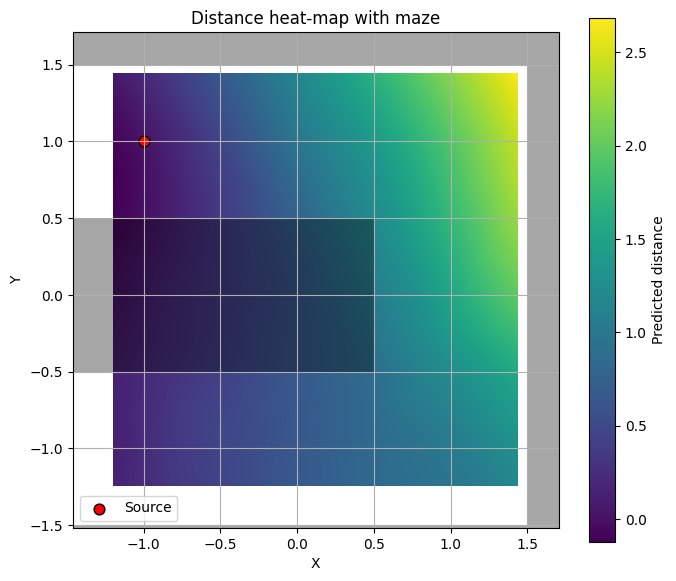

In [10]:
distance_model.plot_distance_heatmap(env, source_point=(-1, 1))